In [1]:
import torch
from torch.utils.data import TensorDataset, Dataset
import torch.optim as optim
import torch.utils.data as data
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import resnet18,ResNet18_Weights
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from torchmetrics.classification import BinaryF1Score
from datetime import datetime

In [3]:
class CustomTensorDataset(Dataset):
    """
    A custom dataset class that works with tensors.

    Args:
    tensors (tuple): A tuple consisting of input data and target data tensors.
    transform (callable, optional): A function to apply data transformations.

    Attributes:
    tensors (tuple): A tuple consisting of input data and target data tensors.
    transform (callable): Data transformation function.
    size (int): Size of the dataset.
    """

    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform
        self.size = tensors[1].shape[0]


    def __getitem__(self, index):
        """
        Gets a data sample from a specific index in the dataset.

        Args:
        index (int): Index value of the data sample.

        Returns:
        tuple: The relevant data sample and its target value.
        """
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        """
        Returns the size of the dataset.
        
        Returns:
        int: Size of the dataset.
        """
        return self.size

In [4]:
def visualize_loss(train_losses,val_losses,val_accuracy):
    """
    A function to visualize training and validation loss along with validation accuracy.
    
    Args:
    train_losses (list): List of training losses.
    val_losses (list): List of validation losses.
    val_accuracy (list): List of validation accuracies.
    """
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14,10))
    ax[0].plot(range(0, len(train_losses) * 10, 10), train_losses, label='Training Loss')
    ax[0].plot(range(0, len(val_losses) * 10, 10), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Loss')
    ax[0].title.set_text('Training and Validation Loss')
    ax[0].legend()

    ax[1].plot(range(0, len(train_losses) * 10, 10), val_accuracy, label='Validation Accuracy')
    ax[1].set_xlabel('Steps')
    ax[1].set_ylabel('Accuracy')
    ax[1].title.set_text('Validation Accuracy')
    plt.savefig('my_plot_resnet.pdf')
    plt.show()

In [5]:
def read_dataset(paths):
    """
    A function that reads images from given file paths.
    
    Args:
    paths (list): List of image file paths.
    
    Returns:
    torch.Tensor: Tensor of the read images.
    """
    images = []
    for path in paths:
        image = cv2.imread(path)
        image = cv2.resize(image,(224,224), interpolation = cv2.INTER_AREA) # Size Scaling
        images.append(image/255) # Value Scaling
    images = np.array(images,dtype=np.float32)
    images = np.transpose(images, (0, 3, 1, 2)) # PyTorch library accepts inputs as (channel, height, width) format
    images = torch.from_numpy(images)
    return images
    

In [6]:
def eval_model(val_loader,model,criterion,device):
    """
    A function to evaluate the model.
    
    Args:
    val_loader (torch.utils.data.DataLoader): Validation data loader.
    model (torch.nn.Module): Model to be evaluated.
    criterion (torch.nn.Module): Loss function.
    device (torch.device): Device used (CPU or GPU).
    
    Returns:
    tuple: Validation Loss, Accuracy, and F1 score.
    """
    model.eval()  
    val_loss = 0
    correct = 0
    total = 0
    f1 = 0
    f1_metric = BinaryF1Score().to(device)
    with torch.no_grad():
        for batch_idx, (paths, labels) in enumerate(val_loader):
            inputs = read_dataset(paths)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item() * batch_size
            predicted = (outputs >= 0.5).squeeze().long()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            f1 += f1_metric(predicted,labels)
               
    accuracy = 100 * correct / total
    f1 = f1 / len(val_loader)
    val_loss = val_loss / len(val_loader)

    return val_loss, accuracy,f1

In [7]:
db_path = 'db.csv'

db = pd.read_csv(db_path)

# Delete the images designated as test files from the database.
db = db[~db.name.isin(test_files)]

# Seperating positive and negative examples
positive_sample = db[db.label == 1]
negative_sample = db[db.label == 0]
print(f"all data shape: {db.shape[0]} positive label number: {positive_sample.shape[0]}, negative label number: {negative_sample.shape[0]}")


# Creating a balanced dataset by sampling an equal number of negative and positive examples.
db = pd.concat([positive_sample, negative_sample.sample(n = positive_sample.shape[0])], ignore_index=True).sample(frac=1).reset_index(drop=True)
img_size = (256,256)


positive label number: 315190, negative label number: 666433


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the ResNet18 architecture with pretrained weights.
model = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)

# CNN blocks are not included in the training process by freezing them.
for param in model.parameters():
    param.requires_grad = False


num_features = model.fc.in_features
model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(p = 0.2),
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(p = 0.2),
        nn.Linear(128, 1),
        nn.Sigmoid(),
)

model = model.to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
f1_metric = BinaryF1Score().to(device)
train_losses = []
val_losses = []
val_accuracy = []

62


In [10]:
batch_size = 32

# Paths and labels of images are taken and a dataset is created.
X = db['img_path'].values
Y = db['label'].values
dataset = CustomTensorDataset(tensors=(X, Y))

# determining train and validation sizes.
train_size = int(0.9 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, validation_size])

# Train and validation dataloaders are created according to the specified batch size.
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#Training Loop
for epoch in tqdm(range(4)):
  running_loss = 0.0

  for batch_idx, (paths, labels) in enumerate(train_loader):
    inputs = read_dataset(paths)
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
      
    outputs = model(inputs)

    loss = criterion(outputs, labels.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    # Loss is calculated for each batch and accumulated cumulatively as we progress.
    running_loss += loss.item() * batch_size
    
    if batch_idx % 300 == 299:
        model.eval()  #
        val_loss = 0
        correct = 0
        total = 0
        f1 = 0
        running_loss = running_loss / 300
        with torch.no_grad():
            for batch_idx, (paths, labels) in enumerate(val_loader):
                inputs = read_dataset(paths)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                val_loss += loss.item() * batch_size
                predicted = (outputs >= 0.5).squeeze().long()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                f1 += f1_metric(predicted,labels)
                   
        accuracy = 100 * correct / total
        f1 = f1 / len(val_loader)
        val_loss = val_loss / len(val_loader)

        # Daha sonra görselleştirilmek üzere train, validasyon lossları ve validasyon accuracy değeri listede saklanır.
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        print(f"train_loss:{running_loss}, val_loss:{val_loss}, accuracy:{accuracy}, f1:{f1.item()} ")
        val_accuracy.append(accuracy)
        running_loss= 0

  # The model and optimizer are saved at each epoch based on the timestamp when they are recorded.
  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict()
  }
  now = datetime.now()
  current_time = now.strftime("Resnet_%H_%M")
  MODEL_PATH = f"model/model_checkpoint{current_time}.pth"
  torch.save(checkpoint, MODEL_PATH)

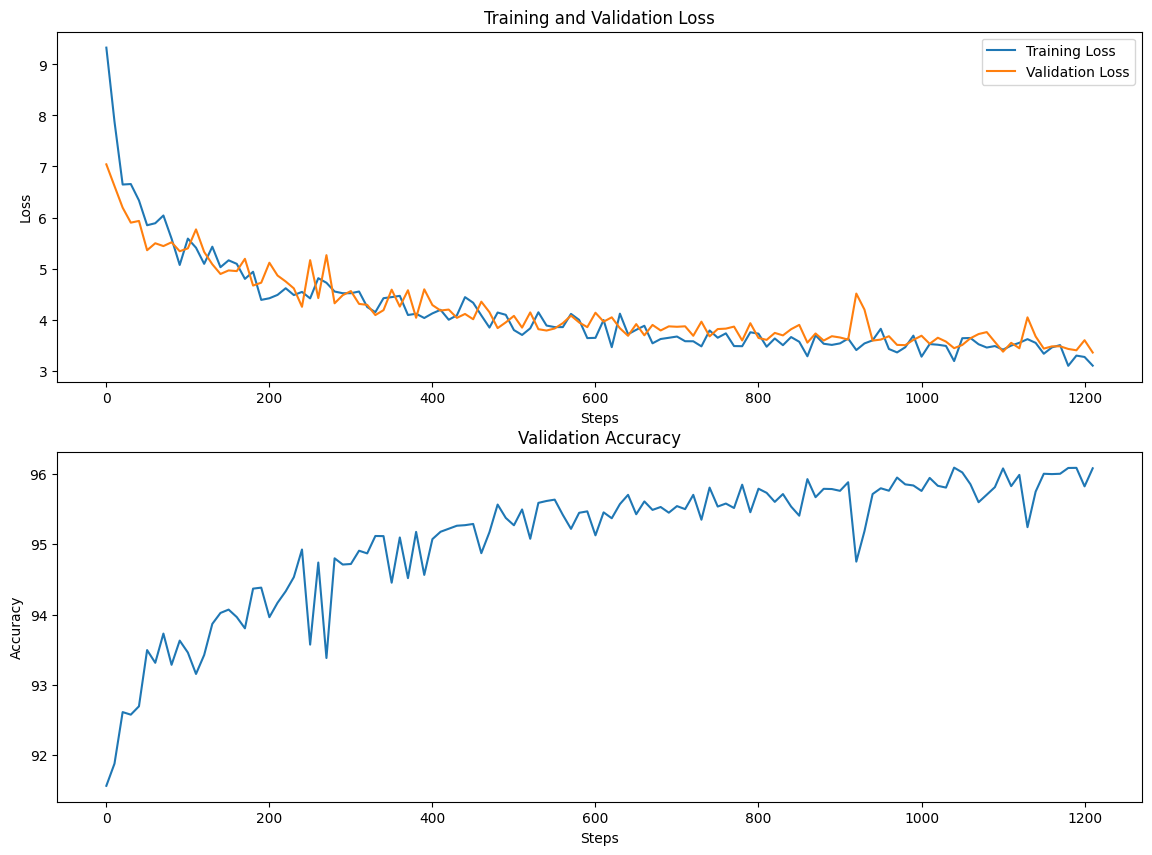

In [12]:
visualize_loss(train_losses,val_losses,val_accuracy)